# Impact on Housing and Community

This notebook shows an analysis of the impact of the war on Gaza for housing and communities. This is done using the following indicators as of February 2nd, 2024 

* Percentage of Residential Buildings Damaged
* Percentage of Places of Worship Damaged
* Percentage of People in Neighbourhoods with Damaged Buildings
* Percentage of Places of Education Damaged
* Places of Public Amenities Damaged
* Percentage of Homes without (observed) Nighttime Lights


In [3]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.cartocolors.qualitative import Prism_10, Vivid_10
from palettable.tableau import ColorBlind_10, TableauMedium_10
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Overall Impact on Housing and Community

In [56]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
summary_stats.reset_index(inplace=True)
summary_stats['ADM2_EN'] = pd.Categorical(summary_stats['ADM2_EN'], categories=sort_order, ordered=True)
summary_stats.sort_values(by='ADM2_EN', inplace=True)
summary_stats.rename(columns = {'ADM2_EN':'Governorate'}, inplace=True)
summary_stats.set_index('Governorate', inplace=True)

In [57]:
summary_stats[['% Residential Buildings Damaged','% Population in Neighborhoods with Damaged Buildings', '% Places of Worship Damaged','% Places of Education Damaged','% Public Amenities Damaged', '% Residential Buildings without Observed Nighttime Lights']].style.background_gradient(cmap='viridis', axis=0).format("{:.0f}%")

,% Residential Buildings Damaged,% Population in Neighborhoods with Damaged Buildings,% Places of Worship Damaged,% Places of Education Damaged,% Public Amenities Damaged,% Residential Buildings without Observed Nighttime Lights
Governorate,,,,,,
North Gaza,35%,54%,80%,80%,80%,46%
Gaza,63%,83%,84%,79%,79%,68%
Deir Al-Balah,36%,23%,60%,72%,72%,89%
Khan Younis,39%,55%,62%,74%,74%,66%
Rafah,18%,10%,35%,71%,71%,5%


## Observations

* The Governorate of Gaza took the greatest impact in almost every indicator being measured. The biggest being the number of people potentially impacted (~720k). 
* The Governorate of North Gaza took impact on Points of Interest. However, this could also be because of the low number of reported buildings in the OpenStreetMap database.
* Khan Younis, a southern Governorate, has more than half its population living in neighborhoods with damaged buildings and without observed nighttime lights.

In [58]:
summary_stats[['Number of Residential Buildings Damaged', 'People in Neighborhoods with Damaged Buildings', 'Number of Places of Worship Damaged', 'Number of Places of Education Damaged','Number of Public Amenities Damaged' ]].style.background_gradient(cmap='viridis', axis=0).format("{:.0f}")

,Number of Residential Buildings Damaged,People in Neighborhoods with Damaged Buildings,Number of Places of Worship Damaged,Number of Places of Education Damaged,Number of Public Amenities Damaged
Governorate,,,,,
North Gaza,174,282283,20,45,45
Gaza,384,720573,49,80,80
Deir Al-Balah,256,84988,12,13,13
Khan Younis,403,261190,21,23,23
Rafah,27,28457,7,24,24


## Percentage of Residential Buildings Damaged

In [4]:
# read shapefiles
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp"
)
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

In [5]:
BUILDINGS_OSM = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_OSM_buildings_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

BUILDINGS_OSM = geopandas.sjoin(BUILDINGS_OSM, GAZA)
BUILDINGS_OSM["type"] = BUILDINGS_OSM["type"].fillna("")

In [6]:
def get_damage_percentage(BUILDINGS_OSM):
    left = (
        BUILDINGS_OSM[BUILDINGS_OSM["_up7mean"] >= 0.2]
        .value_counts(["ADM2_EN", "type"])
        .to_frame("damaged")
    )
    right = BUILDINGS_OSM.value_counts(["ADM2_EN", "type"]).to_frame("total")

    df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
    df["perc"] = 100 * df["damaged"] / df["total"]

    sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
    df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
    df.sort_values(by='ADM2_EN', inplace=True, ascending=False)

    return df

In [60]:
residential = BUILDINGS_OSM[BUILDINGS_OSM['type'].isin(['house', 'apartments', 'residential', 'yes;house'])]
places_of_worship = BUILDINGS_OSM[BUILDINGS_OSM['type'].isin(['religious', 'mosque', 'church'])]

residential.loc[:,'type'] = 'residential'
residential = get_damage_percentage(residential)

places_of_worship.loc[:,'type'] = 'places_of_worship'
places_of_worship = get_damage_percentage(places_of_worship)

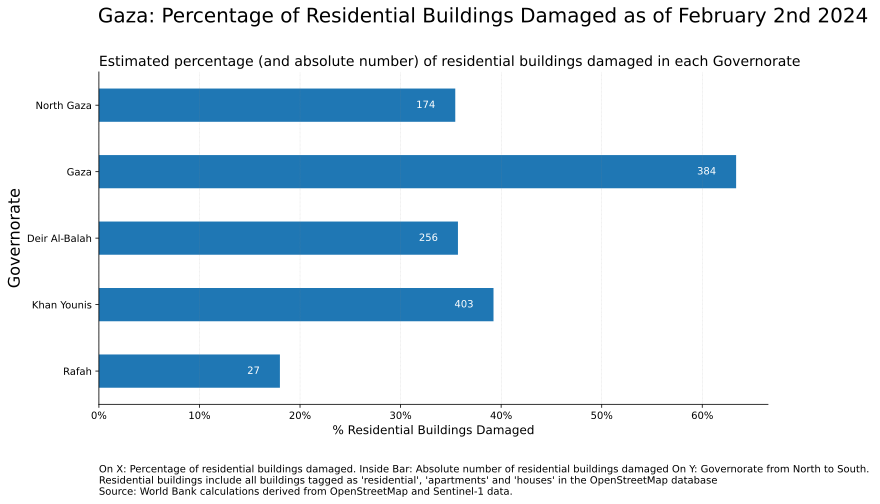

In [61]:
import math

absolute_damage_numbers = list(residential.pivot_table("damaged", "ADM2_EN", "type", observed=False).sort_values(by='ADM2_EN', ascending = False)["residential"])

fig, ax = plt.subplots(figsize=(12, 6))
plt.suptitle("Gaza: Percentage of Residential Buildings Damaged as of February 2nd 2024", y=1.03, fontsize=20, x=0.57)

ax = residential.pivot_table("perc", "ADM2_EN", "type", observed=False)[
    ["residential"]
].sort_values(by='ADM2_EN', ascending = False).plot(kind="barh", legend = False, ax=ax)

ax.set_title(
    "Estimated percentage (and absolute number) of residential buildings damaged in each Governorate",
    fontsize=14,loc='left'
)

# Add labels and customization
ax.set_xlabel("% Residential Buildings Damaged", fontsize=12)

ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend()

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center')


ax.text(
    0,
    -0.23,
    "On X: Percentage of residential buildings damaged. Inside Bar: Absolute number of residential buildings damaged On Y: Governorate from North to South. \nResidential buildings include all buildings tagged as 'residential', 'apartments' and 'houses' in the OpenStreetMap database\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

### Observations and Limitations

* More than 60% of residential buildings in Gaza, the second province from north, can be considered damaged. However, in absolute numbers, Khan Younis has the most number of damaged residential buildings. 
* Residential buildings reported here include all th buildings atagged as 'residential', 'apartments' and 'houses'.
* In the OpenStreetMap database, Deir Al-Balah has 717 reported residential buildings. Khan Younis has 1027, Gaza has 606, North Gaza has 491 and Rafah has 150 reported residential buildings. 
* Khan Younis was declared an evacuation zone by the Israeli Armed Forces which could be a potential rason for the high number of damaged buildings. 

## Percentage of Places of Worship Damaged

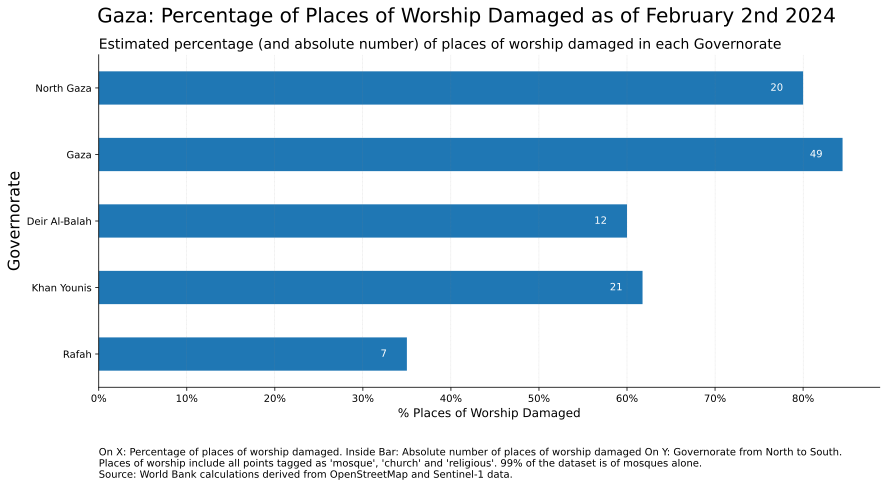

In [81]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.suptitle("Gaza: Percentage of Places of Worship Damaged as of February 2nd 2024", y=0.99, fontsize=20, x=0.49)

absolute_damage_numbers = list(places_of_worship.pivot_table("damaged", "ADM2_EN", "type", observed=False).sort_values(by='ADM2_EN', ascending = False)["places_of_worship"])


ax = places_of_worship.pivot_table("perc", "ADM2_EN", "type", observed = False)[
    ["places_of_worship"]
].sort_values(by='ADM2_EN', ascending = False).plot(ax=ax, kind="barh", legend = False)

# Add labels and customization
ax.set_xlabel("% Places of Worship Damaged", fontsize=12)

ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend()

ax.set_title(
    "Estimated percentage (and absolute number) of places of worship damaged in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.23,
    "On X: Percentage of places of worship damaged. Inside Bar: Absolute number of places of worship damaged On Y: Governorate from North to South. \nPlaces of worship include all points tagged as 'mosque', 'church' and 'religious'. 99% of the dataset is of mosques alone.\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

### Observations and Limitations

* Gaza had the biggest hit on places of worship both in terms of percentage and abolute numbers. 
* There are a total of 58 reported places of worship in Gaza, North Gaza has 25, Deir Al-Balah has 20, Khan Younis has 34 and Rafah has 20.
* There are no reported synagogues. 
* Gaza also has 195 reported ruins, of which 141 (72%) are damaged

## Percentage of People Living in Neighborhoods with Damaged Buildings

In [10]:
from shapely.geometry import Point

def convert_to_gdf(df, X=None, Y=None):
    if 'latitude' in df.columns:
        geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
        gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    else:
        geometry = [Point(xy) for xy in zip(df[Y], df[X])]
        gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [11]:
POPULATION = pd.read_csv('../../data/population/pse_pd_2020_1km_UNadj_ASCII_XYZ/pse_pd_2020_1km_UNadj_ASCII_XYZ.csv')
POPULATION = convert_to_gdf(POPULATION, 'Y', 'X')

POPULATION = POPULATION.sjoin(GAZA)
POPULATION = POPULATION[POPULATION['ADM1_EN']=='Gaza Strip']

In [12]:
import math
from shapely.geometry import Point, box

# Function to create a 1 km^2 box around a point
def create_square_km_box(point):
    lat, lon = point.y, point.x
    km_in_deg_lat = 1 / 111.32  # 1 km in degrees latitude
    km_in_deg_lon = 1 / (111.32 * math.cos(math.radians(lat)))  # 1 km in degrees longitude at this latitude
    
    # Define the bottom left and top right coordinates of the box
    bottom_left = (lon - km_in_deg_lon / 2, lat - km_in_deg_lat / 2)
    top_right = (lon + km_in_deg_lon / 2, lat + km_in_deg_lat / 2)
    
    # Create and return the box
    return box(*bottom_left, *top_right)


POPULATION['geometry'] = POPULATION['geometry'].apply(create_square_km_box)

c:\Users\sahit\anaconda3\envs\conflict-analyses\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [63]:
#POPULATION.drop(columns = 'index_right', inplace=True)
#BUILDINGS_OSM.drop(columns = 'index_right', inplace=True)
population_impacted = POPULATION[['X', 'Y', 'Z', 'geometry', 'ADM2_EN', 'ADM2_PCODE', 'ADM1_EN',
       'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE']].sjoin(BUILDINGS_OSM[BUILDINGS_OSM['type'].isin(['residential', 'house', 'apartments', 'yes;house'])][['osm_id', 'code', 'fclass', 'name', 'type', '_max', 'area','_landusefc', '_up7mean', 'geometry']])

In [64]:
left = POPULATION[['X', 'Y', 'Z', 'ADM2_EN', 'ADM1_EN', 'ADM0_EN']]

# Getting the average damage value for each point
right = population_impacted[['X', 'Y', 'Z', '_up7mean']].groupby(['X', 'Y', 'Z']).mean().reset_index()

population_impacted = left.merge(right, on = ['X', 'Y', 'Z'])

# Threshold for damage
population_impacted = population_impacted[population_impacted['_up7mean']>0.2]

# Grouping by admin region and getting people living in damaged regions
population_impacted = population_impacted.groupby(['ADM0_EN','ADM1_EN','ADM2_EN'])[['Z']].sum().reset_index()
population_impacted.rename(columns={'Z':'damage_population'}, inplace=True)

left = POPULATION[['X', 'Y', 'Z', 'ADM2_EN', 'ADM1_EN', 'ADM0_EN']].groupby(['ADM0_EN', 'ADM1_EN', 'ADM2_EN'])[['Z']].sum().reset_index()
left.rename(columns = {'Z':'total_population'}, inplace=True)

population_impacted = left.merge(population_impacted, on = ['ADM0_EN', 'ADM1_EN', 'ADM2_EN'])

population_impacted['perc'] = 100*population_impacted['damage_population']/population_impacted['total_population']

In [65]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
population_impacted['ADM2_EN'] = pd.Categorical(population_impacted['ADM2_EN'], categories=sort_order, ordered=True)
population_impacted.sort_values(by='ADM2_EN', inplace=True)

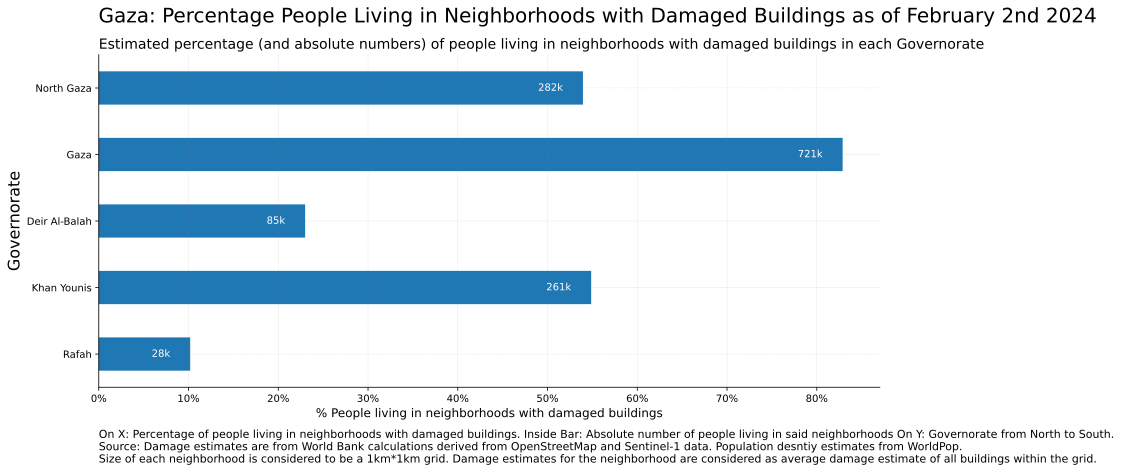

In [76]:
fig, ax = plt.subplots(figsize=(14, 6))
plt.suptitle("Gaza: Percentage People Living in Neighborhoods with Damaged Buildings as of February 2nd 2024", y=0.99, fontsize=20, x=0.62)

absolute_damage_numbers = list(population_impacted.pivot_table( 'damage_population', 'ADM2_EN', observed=False).sort_values(by='ADM2_EN', ascending = False)['damage_population'])


ax=population_impacted[['ADM2_EN', 'perc']].pivot_table( 'perc', 'ADM2_EN', observed=False).sort_values(by='ADM2_EN', ascending = False).plot(
    ax=ax, kind="barh",legend = False #color=['#D62728', '#FF7F0E', '#9467BD', '#17BECF']
)

# Add labels and customization
ax.set_xlabel("% People living in neighborhoods with damaged buildings", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)

#ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage (and absolute numbers) of people living in neighborhoods with damaged buildings in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.18,
    "On X: Percentage of people living in neighborhoods with damaged buildings. Inside Bar: Absolute number of people living in said neighborhoods On Y: Governorate from North to South. \nSource: Damage estimates are from World Bank calculations derived from OpenStreetMap and Sentinel-1 data. Population desntiy estimates from WorldPop.\nSize of each neighborhood is considered to be a 1km*1km grid. Damage estimates for the neighborhood are considered as average damage estimate of all buildings within the grid. ",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=11,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{absolute_damage_numbers[id] / 1_000:.0f}k',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

### Observations 

* Both North Gaza (523k) and Gaza (869k) have higher population than Khan Younis (476k). This is a potential reason for why the damage is higher in Khan Younis but the people impacted are greater in the other two administrative regions.
* The population numbers are derived from WorldPop which uses machine learning code to distribute population density top-down. This means that sometimes, in areas where there are fewer people, the number reported in WorldPop could be higher and vice versa. Therefore, the numbers reported here are the best approximation we can make with the data available. 

## Percentage of Schools and Public Amenities Damaged

In [17]:
POI = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_pois_1_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

POI = geopandas.sjoin(POI, GAZA)
POI["fclass"] = POI["fclass"].fillna("")

In [18]:
def get_poi_classification(fclass):
    if fclass in [
        "school",
        "kindergarten",
        "university",
        "college",
    ]:
        return "Education"
    if fclass in [
        "tower",
        "wastewater_plant",
        "water_tower",
        "telephone",
        "water_well",
        "drinking_water",
        "recycling",
    ]:
        return "Infrastructure"
    if fclass in [
        "pharmacy",
        "dentist",
        "doctors",
        "hospital",
        "clinic",
        "nursing_home",
    ]:
        return "Health"
    if fclass in [
        "public_building",
        "police",
        "courthouse",
        "library",
        "monument",
        "post_office",
        "memorial",
        "community_centre",
        "town_hall",
        "museum",
        "arts_centre",
        "sports_centre",
        "tourist_info",
        "fire_station",
    ]:
        return "Public Amenities"

    elif fclass in [
        "clothes",
        "supermarket",
        "restaurant",
        "laundry",
        "cafe",
        "computer_shop",
        "convenience",
        "furniture_shop",
        "shoe_shop",
        "bakery",
        "hotel",
        "hairdresser",
        "fast_food",
        "bank",
        "viewpoint",
        "artwork",
        "picnic_site",
        "chalet",
        "caravan_site",
        "greengrocer",
        "beauty_shop",
        "car_dealership",
        "attraction",
        "pub",
        "waste_basket",
        "nightclub",
        "playground",
        "department_store",
        "outdoor_shop",
        "atm",
        "butcher",
        "car_rental",
        "doityourself",
        "guesthouse",
        "beverages",
        "theatre",
        "newsagent",
        "cinema",
        "mobile_phone_shop",
        "car_wash",
        "bookshop",
        "hostel",
        "sports_shop",
        "castle",
        "pitch",
        "car_sharing",
        "vending_machine",
        "food_court",
        "gift_shop",
        "camp_site",
        "veterinary",
        "post_box",
        "florist",
        "jeweller",
        "chemist",
        "motel",
        "alpine_hut",
        "mall",
        "kiosk",
        "bicycle_shop",
        "bench",
        "optician",
        "travel_agent",
        "biergarten",
        "toy_shop",
        "bar",
        "fountain",
        "archaeological",
        "shelter",
        "park",
        "stationery",
        "market_place",
        "zoo",
    ]:
        return "Places of Economic Activity"

In [19]:
POI["type"] = POI["fclass"].apply(get_poi_classification)

In [67]:
left = POI[POI["_up7max"] >= 0.5].value_counts(["ADM2_EN", "type"]).to_frame("damaged")
right = POI.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

In [68]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
df.sort_values(by='ADM2_EN', inplace=True)

In [69]:
education = df[df['type']=='Education']
# education = education.pivot_table("perc", "ADM2_EN", "type", observed=False)[['Education']].sort_values(by='ADM2_EN', ascending = False)
education = education[['ADM2_EN', 'damaged', 'total', 'perc']]


public_amenities = df[df['type']=='Education']
# education = education.pivot_table("perc", "ADM2_EN", "type", observed=False)[['Education']].sort_values(by='ADM2_EN', ascending = False)
public_amenities = public_amenities[['ADM2_EN', 'damaged', 'total', 'perc']]

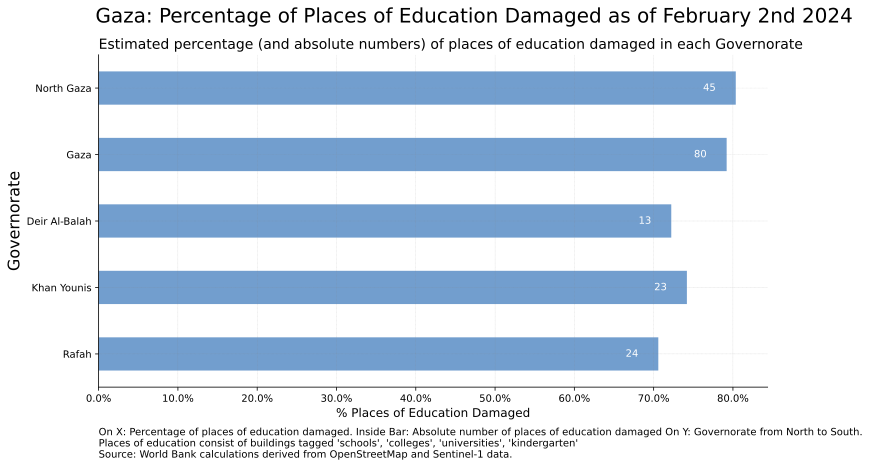

In [73]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
plt.suptitle("Gaza: Percentage of Places of Education Damaged as of February 2nd 2024", y=0.99, fontsize=20, x=0.56)

absolute_damage_numbers = list(df.pivot_table("damaged", "ADM2_EN", "type", observed=False).sort_values(by='ADM2_EN', ascending = False)["Education"])


ax = df.pivot_table("perc", "ADM2_EN", "type", observed=False)[['Education']].sort_values(by='ADM2_EN', ascending = False).plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors, legend = False
)

# Add labels and customization
ax.set_xlabel("% Places of Education Damaged", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
# ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage (and absolute numbers) of places of education damaged in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.17,
    "On X: Percentage of places of education damaged. Inside Bar: Absolute number of places of education damaged On Y: Governorate from North to South. \nPlaces of education consist of buildings tagged 'schools', 'colleges', 'universities', 'kindergarten'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

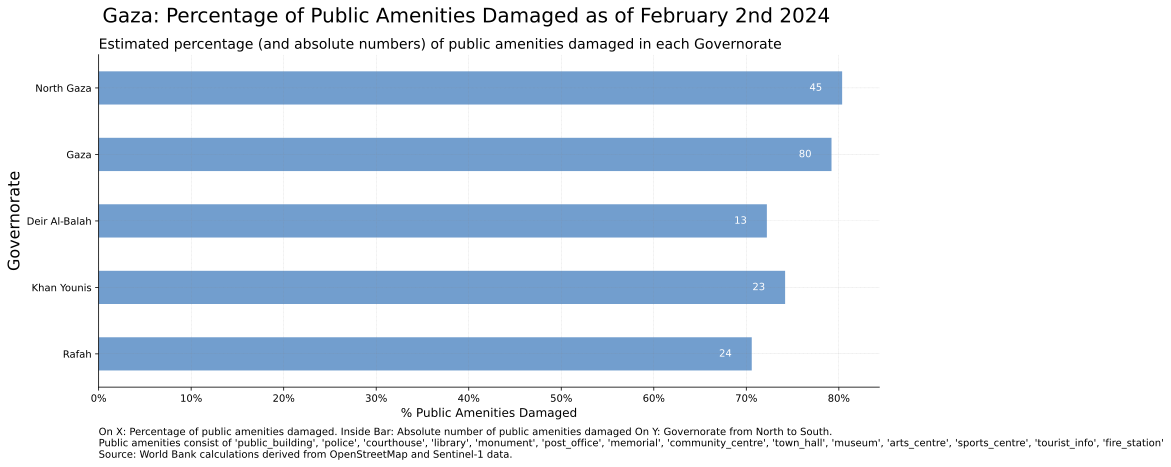

In [85]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
plt.suptitle("Gaza: Percentage of Public Amenities Damaged as of February 2nd 2024", y=0.99, fontsize=20, x=0.49)

absolute_damage_numbers = list(public_amenities.pivot_table("damaged", "ADM2_EN", observed=False).sort_values(by='ADM2_EN', ascending = False)["damaged"])


ax = public_amenities.pivot_table("perc", "ADM2_EN",  observed=False)[['perc']].sort_values(by='ADM2_EN', ascending = False).plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors, legend = False
)

# Add labels and customization
ax.set_xlabel("% Public Amenities Damaged", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
# ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage (and absolute numbers) of public amenities damaged in each Governorate",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.17,
    "On X: Percentage of public amenities damaged. Inside Bar: Absolute number of public amenities damaged On Y: Governorate from North to South. \nPublic amenities consist of 'public_building', 'police', 'courthouse', 'library', 'monument', 'post_office', 'memorial', 'community_centre', 'town_hall', 'museum', 'arts_centre', 'sports_centre', 'tourist_info', 'fire_station'\nSource: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

for id, bar in enumerate(ax.patches):
    width = bar.get_width()  # Use width since the bars are horizontal
    ax.annotate(f'{int(np.round(absolute_damage_numbers[id],0))}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(-20, 0),  # Shift the text to the left of the bar's end
                textcoords="offset points",color = 'white',
                ha='right', va='center');

## Percentage of Residential Buildings without Observed Nighttime Lights

Lower nighttime lights intensity indicative of darker areas may correspond to higher numbers of residential buildings without electricity. The chart below shows the percentage of residential buildings retrieved from [OpenStreetMap](https://www.hotosm.org) for which the nighttime lights intensity has decreased as of December 2023 by at least 95% compared to September 2023 for each governorate in Gaza.

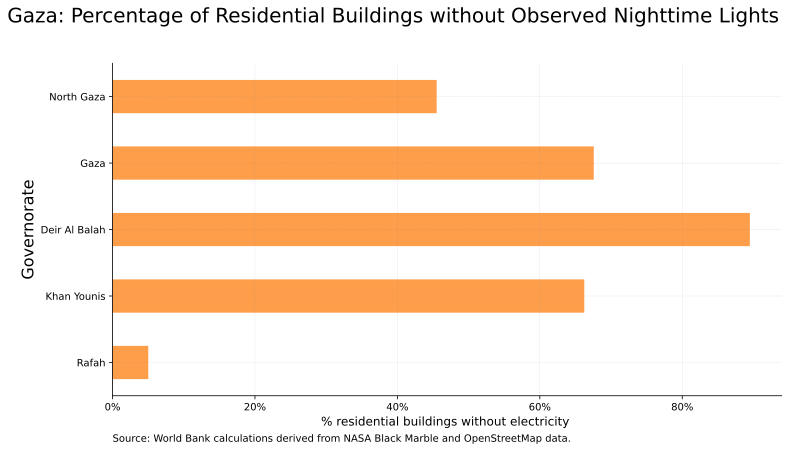

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.suptitle("Gaza: Percentage of Residential Buildings without Observed Nighttime Lights", y=1.01, fontsize=20, x=0.45)

data = pd.read_csv("../../data/ntl/PSE_2-buildings_without_electricity.csv", index_col="name")[['% residential buildings without electricity']].plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors[1], legend = False
)

# Add labels and customization
ax.set_xlabel("% residential buildings without electricity ", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0f}%".format(y)))
ax.set_ylabel("Governorate", fontsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)

# ax.set_title(
#     "Estimated percentage of buildings without electricity for each governorate",
#     fontsize=14,
# )
ax.text(
    0,
    -0.13,
    "Source: World Bank calculations derived from NASA Black Marble and OpenStreetMap data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

In [29]:
#population_impacted.rename(columns = {'perc':'% Population in Neighborhoods with Damaged Buildings','damage_population':'People in Neighborhoods with Damaged Buildings'}, inplace=True)
residential.rename(columns = {'damaged':'Number of Residential Buildings Damaged', 'total':'residential_total', 'perc':'% Residential Buildings Damaged'}, inplace=True)
places_of_worship.rename(columns = {'damaged':'Number of Places of Worship Damaged', 'total':'places_of_worship_total', 'perc':'% Places of Worship Damaged'}, inplace=True)
education.rename(columns = {'damaged':'Number of Places of Education Damaged', 'total':'education_total', 'perc':'% Places of Education Damaged'}, inplace=True)
public_amenities.rename(columns = {'damaged':'Number of Public Amenities Damaged', 'total':'public_amenities_total', 'perc':'% Public Amenities Damaged'}, inplace=True)

In [37]:
ntl = pd.read_csv("../../data/ntl/PSE_2-buildings_without_electricity.csv", index_col="name")[['% residential buildings without electricity']]
ntl.rename(columns = {'% residential buildings without electricity':'% Residential Buildings without Observed Nighttime Lights'}, inplace=True)

In [38]:
ntl = ntl.reset_index()
ntl.rename(columns = {'name':'ADM2_EN'}, inplace=True)

In [39]:
from functools import reduce

summary_stats_list = [residential, places_of_worship, population_impacted, education, public_amenities, ntl]
summary_stats = reduce(lambda left, right: pd.merge(left, right, on='ADM2_EN', how='outer'), summary_stats_list)

summary_stats.drop(columns=['type_x', 'type_y'], inplace=True)

summary_stats.set_index('ADM2_EN', inplace=True)


In [40]:
summary_stats.to_csv('../../data/summary_stats_housing_community.csv')